In [1]:
import pandas as pd
import os
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 2)

import outlier

This data was provided by Transport for NSW. It is the train turnstile "validation" data from 2013 to June 2016.

It includes:
* Date: The date of the reading. If the reading is early in the morning the date is the prior day. This is done so all trips between 5pm and 5am are considered the same date.
* Time: The timeperiod the reading was taken. This is in the format "17 to 18" and is supposed to range from "17 to 18" to "26 to 27" where
 * "17 to 18" means 5pm - 6pm of the current date
 * "25 to 26" means 1pm-2pm the next day
* Line: The train line 
* Station: The tran station
* Exit:    The number of people exiting in that hour
* Entry:   The number of people entering in that hour
* Night:   We added name of the day for the date of the reading, e.g., Friday.

We found that Time also included "0 to 1" and "1 to 2", whic we assume means 1am of the current date. These are rows are corrected so the date is the prior day and the Time is "24 to 25" or "25 to 26"

# Import and clean data

Read in the 4 years of zipped CSV data as a single dataframe. Convert Source, Line, Station and Times to categoricals to save space and speed processing.

In [ ]:
DIR='TrainValidationData/'
df = pd.concat([pd.read_csv(DIR+file, names=['Source', 'Line','Time', 'Station', 'Entry', 'Exit', 'Date'], 
                             na_values=['', ' '], converters={'Entry':int, 'Exit':int}, header=0) 
                 for file in os.listdir(DIR)])

df.Source = df.Source.astype('category')
df.Line = df.Line.astype('category')

stations = ['Kings Cross Station', 'Newtown Station', 'Parramatta Station',
'Town Hall Station', 'Central Station', 'Circular Quay Station', 'Martin Place Station', 'Museum Station', 'St James Station', 
'Bondi Junction Station', 'North Sydney Station']
df.Station = df.Station.astype('category', ordered=True, categories=stations)

Calculate Datetime as a time stamp using Date + the hour of the Time

In [ ]:
BANDS = ["{} to {}".format(i,i+1) for i in range(0,27)]
df.Time = df.Time.astype('category', ordered=True,  categories=BANDS)

df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y %H:%M')
df['Datetime'] = df.Date + pd.to_timedelta(df.Time.cat.codes, unit='h')

Remove items before Friday 5pm or after Monday 5pm as these are not part of our study.

In [ ]:
df['Night'] = df.Date.dt.weekday_name.astype('category')
df = df[~((df.Time < '17 to 18') &  (df.Night == 'Friday'))]
df = df[~((df.Time >= '17 to 18') &  (df.Night == 'Monday'))]

Recompute Date so all observations between 5pm and 5am have the same date. Create Night as the name of that day, e.g., Friday

In [ ]:
df.Date = pd.to_datetime((df['Datetime'] - timedelta(hours = 6)).dt.date)

df['Night'] = df.Date.dt.weekday_name.astype('category', ordered=True, 
                                             categories=['Friday', 'Saturday', 'Sunday'])

hours = ['05PM', '06PM', '07PM', '08PM', '09PM', '10PM', '11PM', '12AM','01AM', '02AM']
df.Time = (df.Datetime.dt.strftime('%I%p').
                           astype('category', ordered=True, categories=hours))

Since there are multiple lines for the same date/station/Time, aggegrate to create one per "observation"

In [ ]:
df = df.groupby(['Station','Night', 'Time','Date'], as_index=False).agg({'Entry':'sum', 'Exit':'sum'})
print(len(df), "observations from", df.Date.min(), "to", df.Date.max())

In [ ]:
df.to_pickle("TrainValidationData/df.pkl")

# Check and Clean Data



## Missing data

Our first check is for whole days that are missing for a station. In this section we discover that:
1. Most stations are missing 1% to 2% of day, but Newtown Station is missing 10% (58 days) 
2. The missing Newtown data is largely on a Saturday and Sunday

In [6]:
df = pd.read_pickle("TrainValidationData/df.pkl")

In [25]:
xx = df.pivot_table(index = 'Date', columns = ['Station'], values='Exit', aggfunc=sum)
print("Number of days", len(xx))
for station in xx.columns:
    print("{:>22}: {:}".format(station, xx[station].isnull().sum()))

Number of days 549
   Kings Cross Station: 14
       Newtown Station: 58
    Parramatta Station: 6
     Town Hall Station: 0
       Central Station: 2
 Circular Quay Station: 13
  Martin Place Station: 10
        Museum Station: 16
      St James Station: 17
Bondi Junction Station: 11
  North Sydney Station: 12


In the above wesee number of days where there was no data for the entier period (5pm-2am). We see that: 
- Town Hall has no missing days and Centeral only 2 
- Paramatta is about 1% missing days
- All other except Newtown are around 2%
- Newtown is 10% and needs closers investigation

In the following we see the how often data is missing for a specific time of day.

In [30]:
(df.pivot_table(index = 'Date', columns = ['Station', 'Time'], values='Exit', aggfunc=sum).
     isnull().
     sum().reset_index().
     pivot('Station', 'Time', 0))

Time,05PM,06PM,07PM,08PM,09PM,10PM,11PM,12AM,01AM,02AM
Station,,,,,,,,,,
Kings Cross Station,27,26,28,29,29,30,29,23,134,499
Newtown Station,93,92,96,112,111,178,197,184,319,470
Parramatta Station,15,12,15,13,18,19,20,15,76,403
Town Hall Station,0,0,0,0,0,0,0,0,36,435
Central Station,2,2,2,2,2,5,6,6,6,33
Circular Quay Station,27,27,27,30,30,33,32,20,214,528
Martin Place Station,21,22,24,23,25,62,92,142,272,525
Museum Station,32,36,36,35,36,119,118,127,290,536
St James Station,31,32,32,41,144,157,170,192,369,537


Looking more closely at Newtown Station, we can see below that most of the missing days are on a Saturday or Sunday from Feb to Aug in  2013. There are two possible explainations:
1. Newtown is a small station where it was common practice to leave the turnstiles open so data is not collected.
2. Newtown station was refurbished, however this seems to have happend between Jan 2011 and Nov 2012 and is the wrong period.

In [10]:
for dt in xx[xx['Newtown Station'].isnull()].index:
    print(dt, dt.weekday_name)

2013-02-02 00:00:00 Saturday
2013-02-03 00:00:00 Sunday
2013-02-09 00:00:00 Saturday
2013-02-10 00:00:00 Sunday
2013-02-16 00:00:00 Saturday
2013-02-17 00:00:00 Sunday
2013-02-23 00:00:00 Saturday
2013-02-24 00:00:00 Sunday
2013-03-02 00:00:00 Saturday
2013-03-09 00:00:00 Saturday
2013-03-10 00:00:00 Sunday
2013-03-16 00:00:00 Saturday
2013-03-17 00:00:00 Sunday
2013-03-23 00:00:00 Saturday
2013-03-24 00:00:00 Sunday
2013-03-29 00:00:00 Friday
2013-03-30 00:00:00 Saturday
2013-03-31 00:00:00 Sunday
2013-04-06 00:00:00 Saturday
2013-04-07 00:00:00 Sunday
2013-04-13 00:00:00 Saturday
2013-04-14 00:00:00 Sunday
2013-04-20 00:00:00 Saturday
2013-04-21 00:00:00 Sunday
2013-04-27 00:00:00 Saturday
2013-04-28 00:00:00 Sunday
2013-05-04 00:00:00 Saturday
2013-05-05 00:00:00 Sunday
2013-05-11 00:00:00 Saturday
2013-05-12 00:00:00 Sunday
2013-05-18 00:00:00 Saturday
2013-06-22 00:00:00 Saturday
2013-06-23 00:00:00 Sunday
2013-06-29 00:00:00 Saturday
2013-06-30 00:00:00 Sunday
2013-07-13 00:00:00

Looking at this data, these are consecuative Sat & Sun days from 2013-02-02 to 2013-11-03. The most likely explaination is before the lockout laws, Newtown gates were open on the weekends and people did not use the turnstiles to pass out. Around the time of the lockout laws this patter changes

## Outliers

In this section we look for outliers, using the IQR method, and replace using interpolation.

In [2]:
df = pd.read_pickle("TrainValidationData/df.pkl").set_index(['Date'])

The following timeseries plots of the Exit are broken by Station and  by Time. For each plot:
- A blue line displays the time series data.
- A red line shows the trend line, i.e., line of best fit
- The magenta dots are outliers.

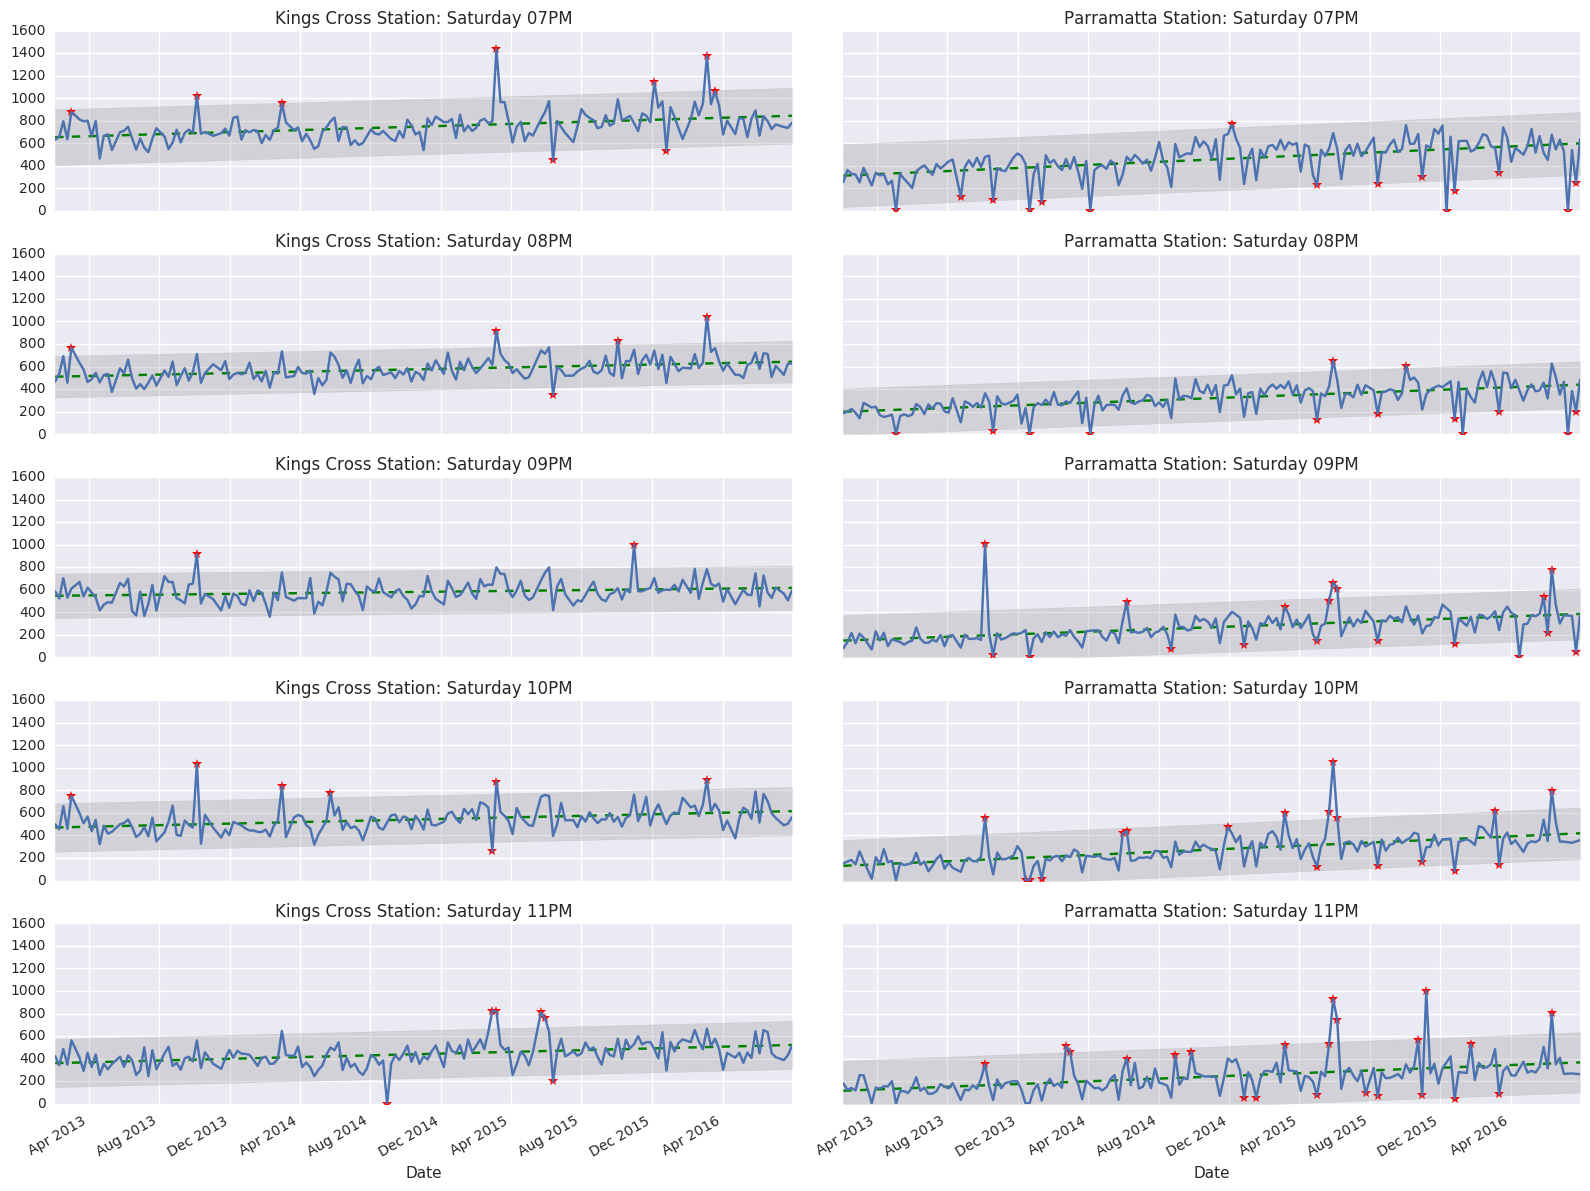

In [6]:
#Plot the data showing trend and outliers using IQR
fig, grid = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(16, 12))
for time, axes in zip(["07PM", "08PM", "09PM", "10PM", "11PM", "12PM"], grid):
    for station, ax in zip(["Kings Cross Station", "Parramatta Station"], axes):
        ts = df.query('Station == @station and Night == "Saturday" and Time == @time')
        outlier.plot(ts.Exit, outliers="True", interval=True, find="IQR", ax=ax).set_ylim((0,None))
        ax.set_title(station + ": Saturday " + time)

plt.tight_layout()

While there are some outliers, especially Newtown, the data looks ok. Using the IQR method we find the outliers and replace them with an interpolated value from the data on either side of the outlier. 

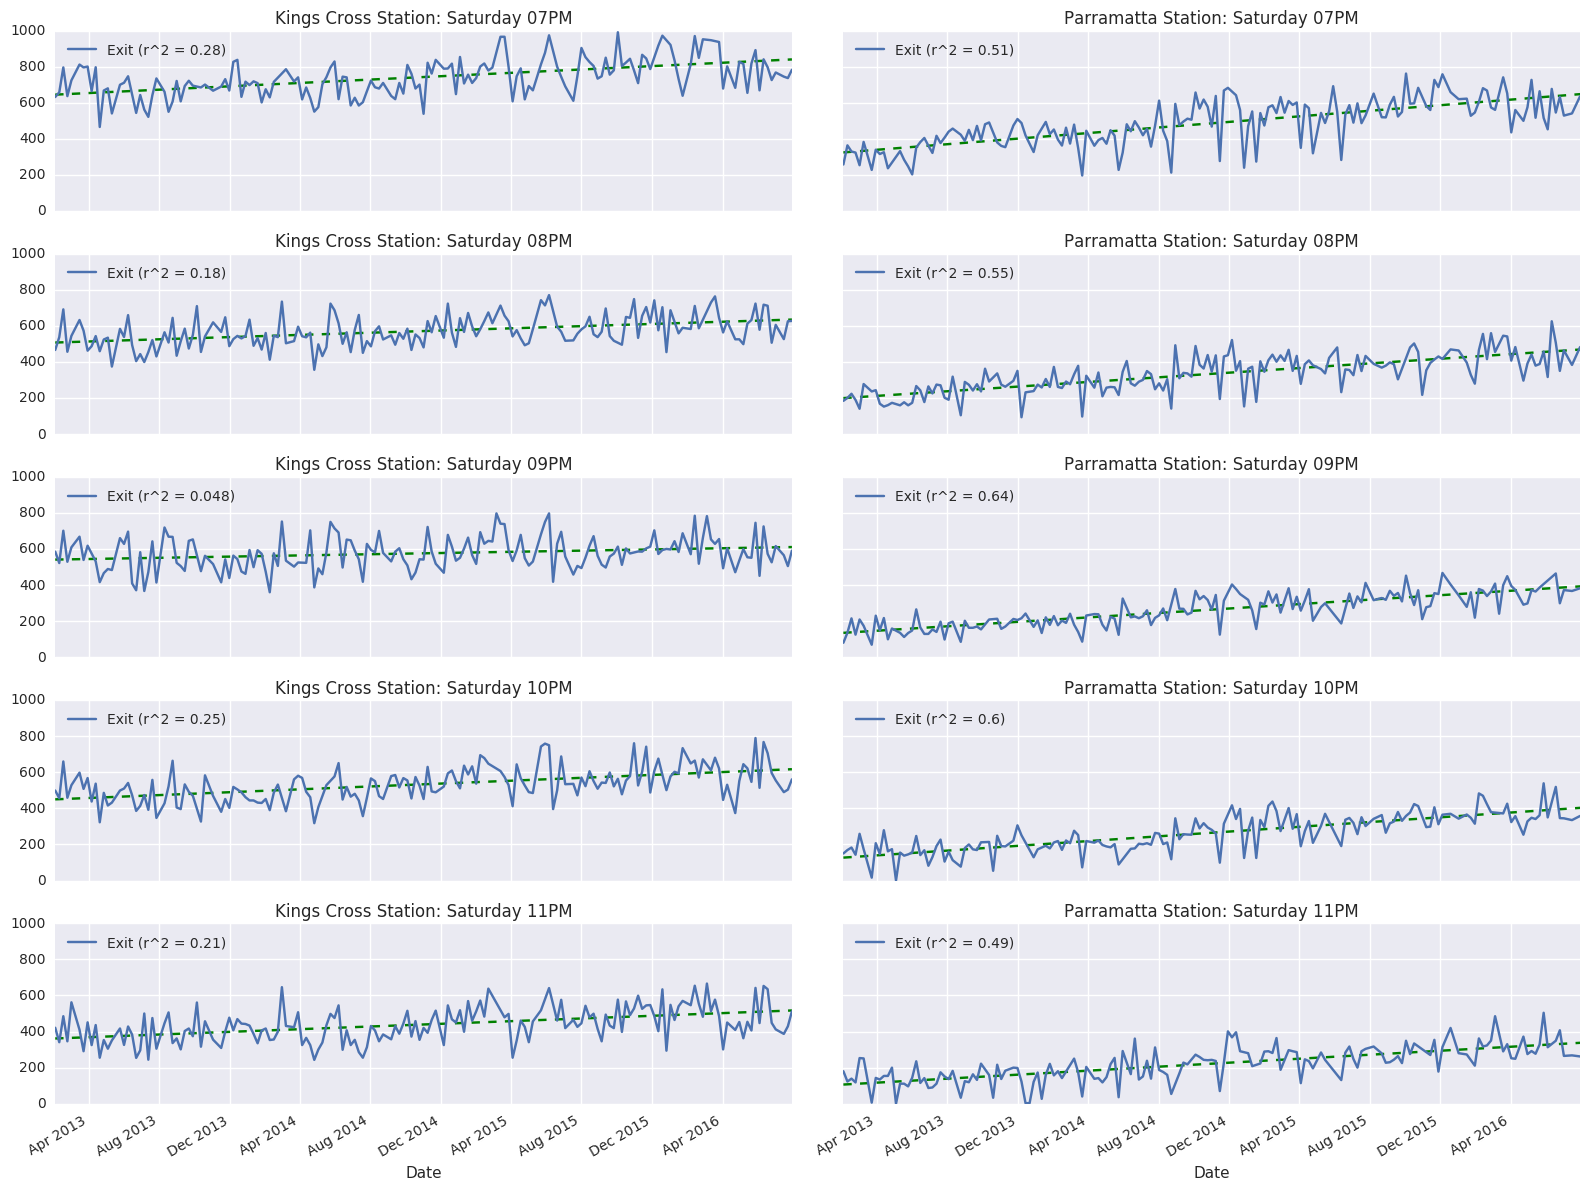

In [8]:
# Clean and plot the data
df_clean = df.copy()
df_clean[['Entry', 'Exit']] = (df.groupby(['Station', 'Night', 'Time'], as_index=False)[['Entry', 'Exit']].
                                   apply(outlier.replace, how='linear'))

assert len(df) == len(df_clean), "Length of cleaned data is incorrect"

fig, grid = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(16, 12))
for time, axes in zip(["07PM", "08PM", "09PM", "10PM", "11PM", "12PM"], grid):
    for station, ax in zip(["Kings Cross Station", "Parramatta Station"], axes):
        ts = df_clean.query('Station == @station and Night == "Saturday" and Time == @time')
        outlier.plot(ts.Exit, ax=ax).set_ylim((0,None))
        ax.set_title(station + ": Saturday " + time)
        ax.legend(loc="upper left")

plt.tight_layout()

This plot shows that the hour by hour data is now generally clean

In [9]:
df_clean.to_pickle("TrainValidationData/df_clean.pkl")

# Explore time/day of week data

Note:
1. Since we are interested in Nightlife we only show data for Fiday and Saturday.
2. To eliminate commuter traffice we only used data from 7PM onwards.
3. To avoid biases from the days of missing data we use averges rather than totals

In [17]:
# Load the clean data and prepare
df_clean = pd.read_pickle("TrainValidationData/df.pkl")
df_clean = df_clean[df_clean.Time >= "07PM"] # Eliminate date before 7PM
df_clean = df_clean[df_clean.Night != "Sunday"] # Eliminate Sunday Data

df_clean['Year'] = df_clean.Date.dt.year
df_clean['Quarter'] = pd.to_datetime(pd.DataFrame({"Year": df_clean.Date.dt.year, "Month": (df_clean.Date.dt.quarter-1)*3+1, "Day":1 }))

stations = ['Kings Cross Station', 'Newtown Station', 'Parramatta Station',
            'Town Hall Station', 'Central Station', 'Circular Quay Station', 
            'Martin Place Station', 'Museum Station', 'St James Station', 
            'Bondi Junction Station', 'North Sydney Station']

The following charts showof the 2013-15 average hourly Exit volumes, broken down by Night by Station. We see:
- The hourly volumes generally decline over time as might be reasonably expected.
- On Friday night the 5pm and 6pm exit traffic is much higher than on Saturday or Sunday, especially in  Parramatta. This is likely to be commuters heading home. In subsequet analysis we will only consider data from 7pm onwards.
- Since the 2013 Newtown Sat data is largely missing we need to be careful interpreting that data, however the use of averages rather than totals minimises the impact

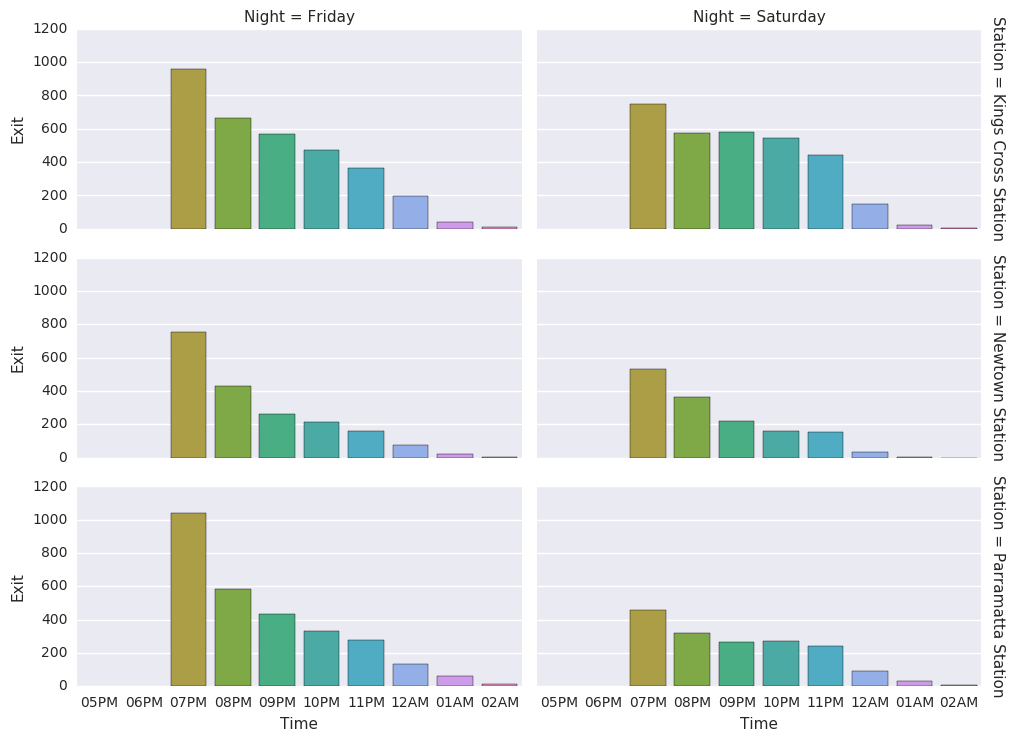

In [19]:
sns.factorplot(data=df_clean, x='Time', y='Exit', kind="bar", 
               row="Station", row_order=stations[:3], col = 'Night', col_order=['Friday', 'Saturday'],
               size=2.5, aspect=2, ci = None, margin_titles = True)

Lets look at the average nightly Exit volumes per year, broken by Night by Station. 
- The highter volumes on a Friday are probably due to commuters heading home at 5pm and 6. See charts above. 
- For all stations the volumes increased between 2013 and 2015. Note the Newtown data for 2013 on Saturday and Sunday is much lower than 2014/16 as most of that years data is missing for Newtown.

What is most noticable, is the volume of train exits in Kings cross increased between 2013 and 2016, indicating that the lockout laws did not impact train usage. 

Note even though we are using averages, since:
- the 2016 data only contains half a year's data.
- Newtown on Saturday is missing the first 9 months of data
These figure need to be used with care.

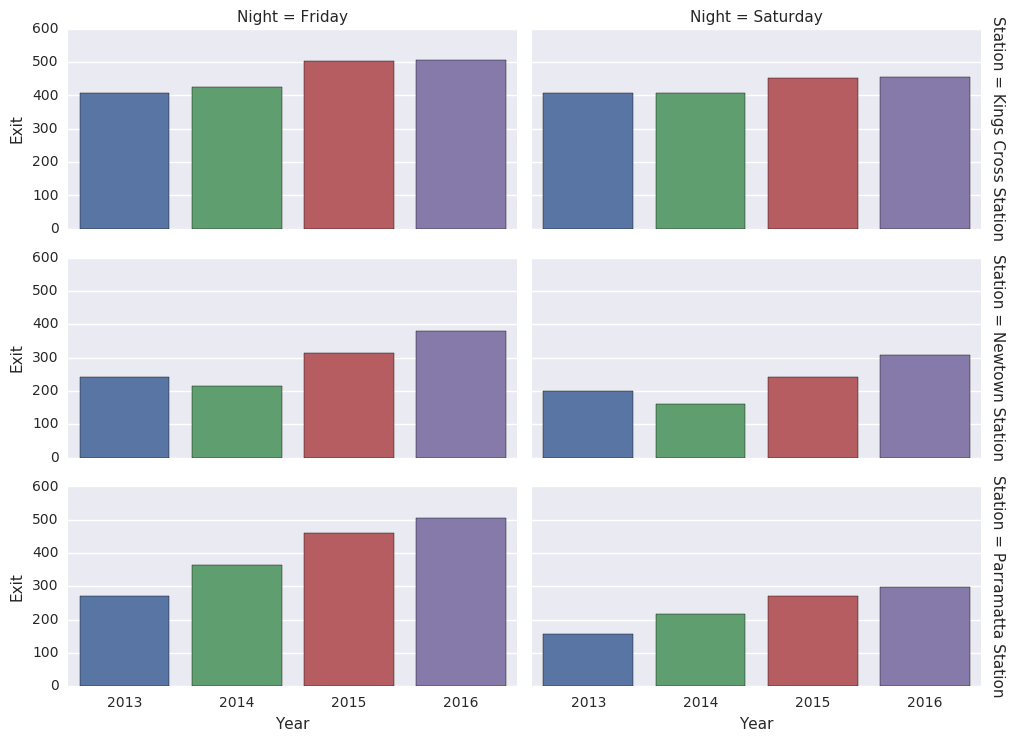

In [20]:
sns.factorplot(data=df_clean, x='Year', y='Exit', kind="bar", 
               row="Station", row_order=stations[:3], 
               col = 'Night', col_order=['Friday', 'Saturday'],
               size=2.5, aspect=2, ci = None, margin_titles = True)

Plotting  Exit data from 7pm onwards, by Night by Station shows:
* Kings cross volumes were not impacted by the lockout laws
* Newtown and Parramatta volumes on a Friday ahve increased significantly in the last few years. 

Note Newtown data for Sat/Sun must be interpreted with case due most data for 2013 not being recorded.

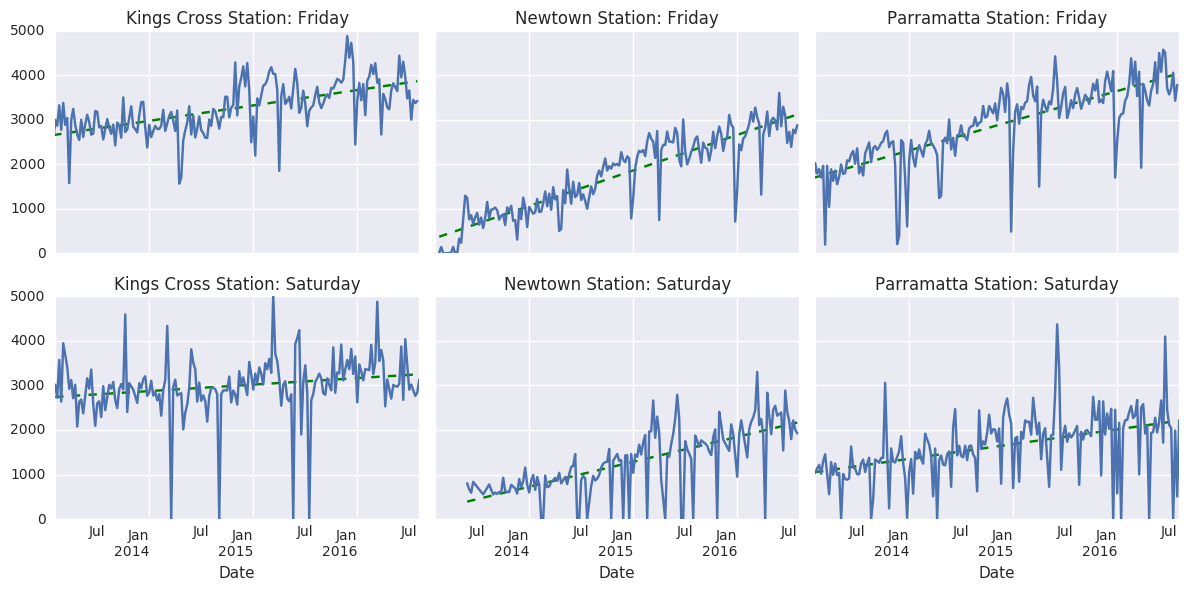

In [23]:
fig, grid = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(12, 6))
fig.autofmt_xdate()

for night, axes in zip(['Friday', 'Saturday'], grid):
    for station, ax in zip(["Kings Cross Station", "Newtown Station", "Parramatta Station"], axes):
        ts = (df_clean.query('Station == @station and Night == @night').
                       groupby('Date').sum())
        outlier.plot(ts.Exit, ax=ax, outlier=True).set_ylim((0,5000))
        ax.set_title(station + ": " + night)
        
plt.tight_layout()

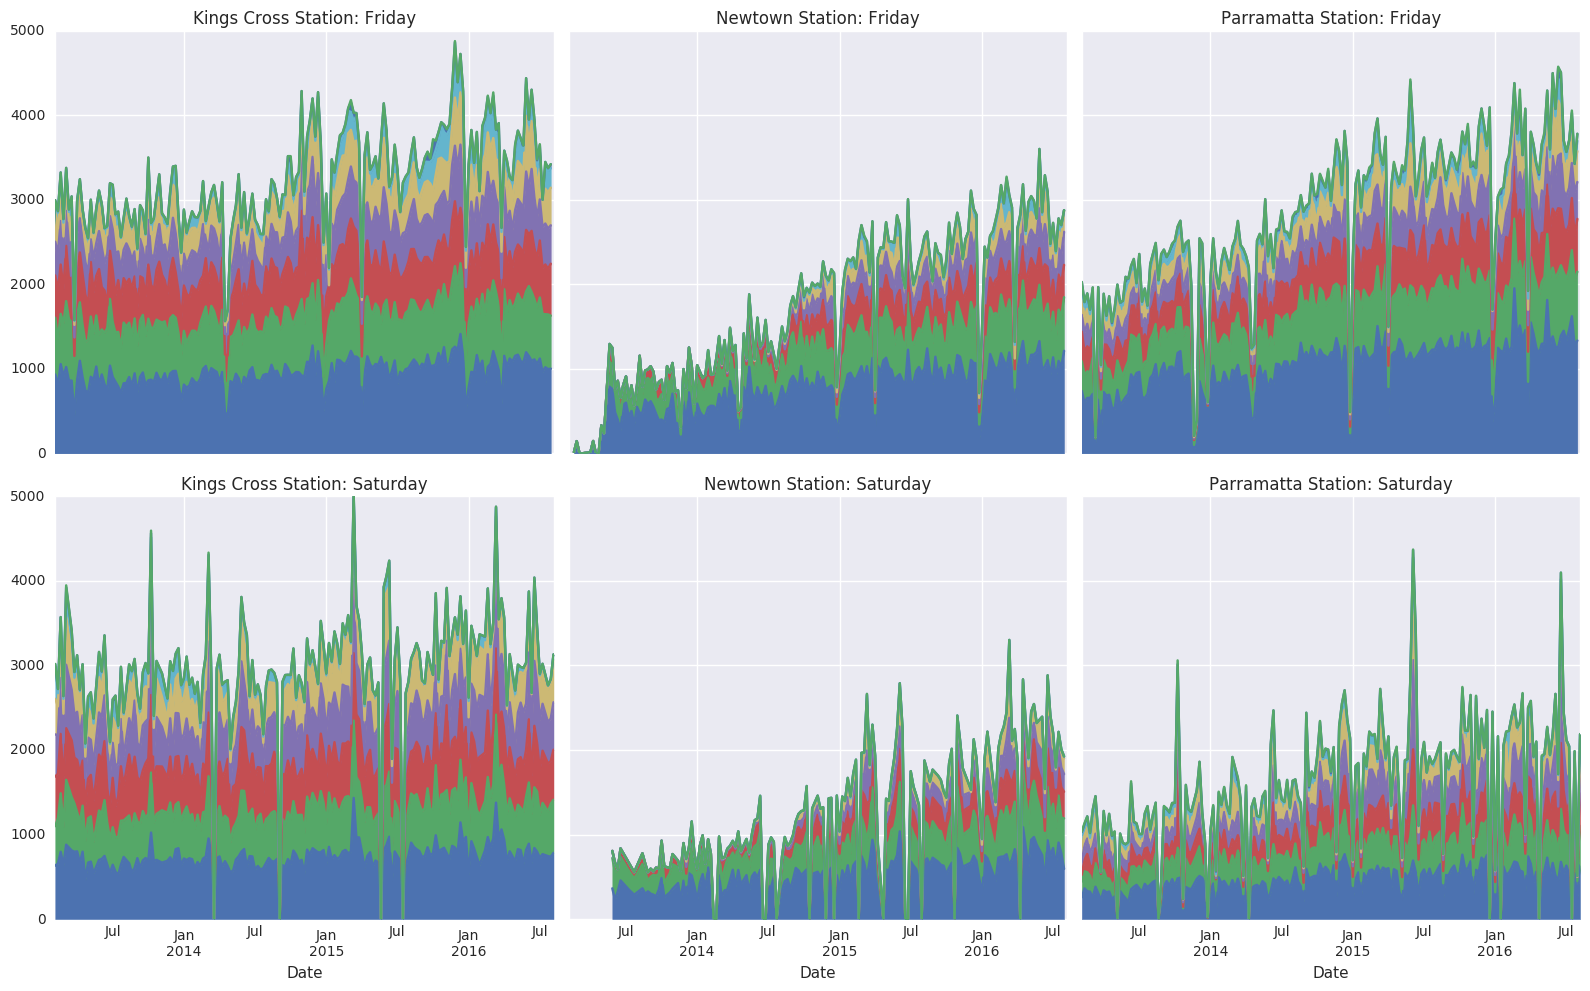

In [26]:
fig, grid = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(16, 10))

for night, axes in zip(['Friday', 'Saturday'], grid):
    for station, ax in zip(["Kings Cross Station", "Newtown Station", "Parramatta Station"], axes):
        (df_clean.query('Station == @station and Night == @night').
                       pivot('Date', 'Time', 'Exit').plot.area(ax=ax, legend=None))
        ax.set_title(station + ": " + night)
        
plt.tight_layout()

## Autocorrelation

In [ ]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(ts):

    ts.plot(y='Exit', ax = plt.subplot2grid((2,3), (0,0), colspan=3))
    smt.graphics.plot_acf(ts, ax=plt.subplot2grid((2,3), (1,0)))
    smt.graphics.plot_pacf(ts,  ax=plt.subplot2grid((2,3), (1,1)))
    sm.qqplot(ts,  line='s',  ax= plt.subplot2grid((2,3), (1,2)))
    plt.tight_layout()

The autocorrolation plot of the Kings Cross, Saturday Night 7PM+ data indicates minimial seasonal effects

In [ ]:
ts = (df_clean.query('Station == "Kings Cross Station" and Night == "Friday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

In [ ]:
ts = (df_clean.query('Station == "Kings Cross Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

In [ ]:
ts = (df_clean.query('Station == "Newtown Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

In [ ]:
ts = (df_clean.query('Station == "Parramatta Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)